In [1]:
import pandas as pd
import numpy as np
import os
import talib
import scipy.optimize as sco
from scipy.stats import norm

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from price_functions import PricesDataFrame
from utils import logreturn_to_return, return_to_logreturn, value_at_risk
import math

df_entry = pd.DataFrame.from_csv('ativos.csv')
df_prices = PricesDataFrame(df_entry[:])
df_prices_test = PricesDataFrame(df_entry[:])

In [2]:
#Abrir dados

appended_data = []
date_format = '%Y-%m-%d'

for entry in os.scandir('../data_crypto/USDT'):
    if entry.is_file():
        symbol = (os.path.splitext(entry.name)[0])
        df_entry = pd.read_json(entry.path)
        df_entry = df_entry[['date','open', 'close', 'high', 'low']]
        df_entry['symbol'] = symbol
        appended_data.append(df_entry)


data = pd.concat(appended_data)
data = data.set_index('date')
data = data.pivot(columns='symbol', values='close').dropna()

In [3]:
data.describe()

symbol,USDT_BCH,USDT_BTC,USDT_DASH,USDT_ETC,USDT_ETH,USDT_LTC,USDT_NXT,USDT_REP,USDT_STR,USDT_XMR,USDT_XRP,USDT_ZEC
count,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000
mean,956.020620,7905.924051,404.396394,17.925812,488.782124,109.930218,0.179311,32.867301,0.228978,172.565264,0.582500,261.311917
std,581.660760,2963.246078,257.708637,7.589173,256.434957,65.501734,0.223248,19.835514,0.153158,88.219735,0.436867,128.701111
min,297.900000,3225.000000,136.542230,7.864945,182.907678,42.793897,0.050899,11.242692,0.010571,46.460000,0.152500,107.827012
25%,526.161431,6340.389548,221.989062,12.147492,294.638469,57.067147,0.068779,18.452553,0.124318,106.603394,0.259568,173.223067
50%,754.894711,7005.000000,314.811991,15.865069,430.900000,82.344104,0.107704,28.550000,0.230000,133.543959,0.479379,230.562687
75%,1260.693000,8908.850000,494.454407,21.381711,661.000000,148.719895,0.186435,39.807354,0.299800,226.956540,0.708500,307.510556
max,3709.440000,19223.000000,1428.000000,42.541200,1382.000000,355.000000,1.761582,105.500000,0.886000,475.000000,2.830000,752.299999


In [4]:
TAMANHO_TREINO = 0.5
qt_dados_treinamento = int(round((len(data)*TAMANHO_TREINO), 0))
df_prices = PricesDataFrame(data[:qt_dados_treinamento]) 
df_prices_test = PricesDataFrame(data[qt_dados_treinamento:])
df_prices_all = PricesDataFrame(data)

In [5]:
df_returns = df_prices.returns()

In [27]:
value_at_risk(0.95, df_prices.mean_returns().loc['USDT_BTC'], df_prices.variance().loc['USDT_BTC'], 100)

-9.078403339561925

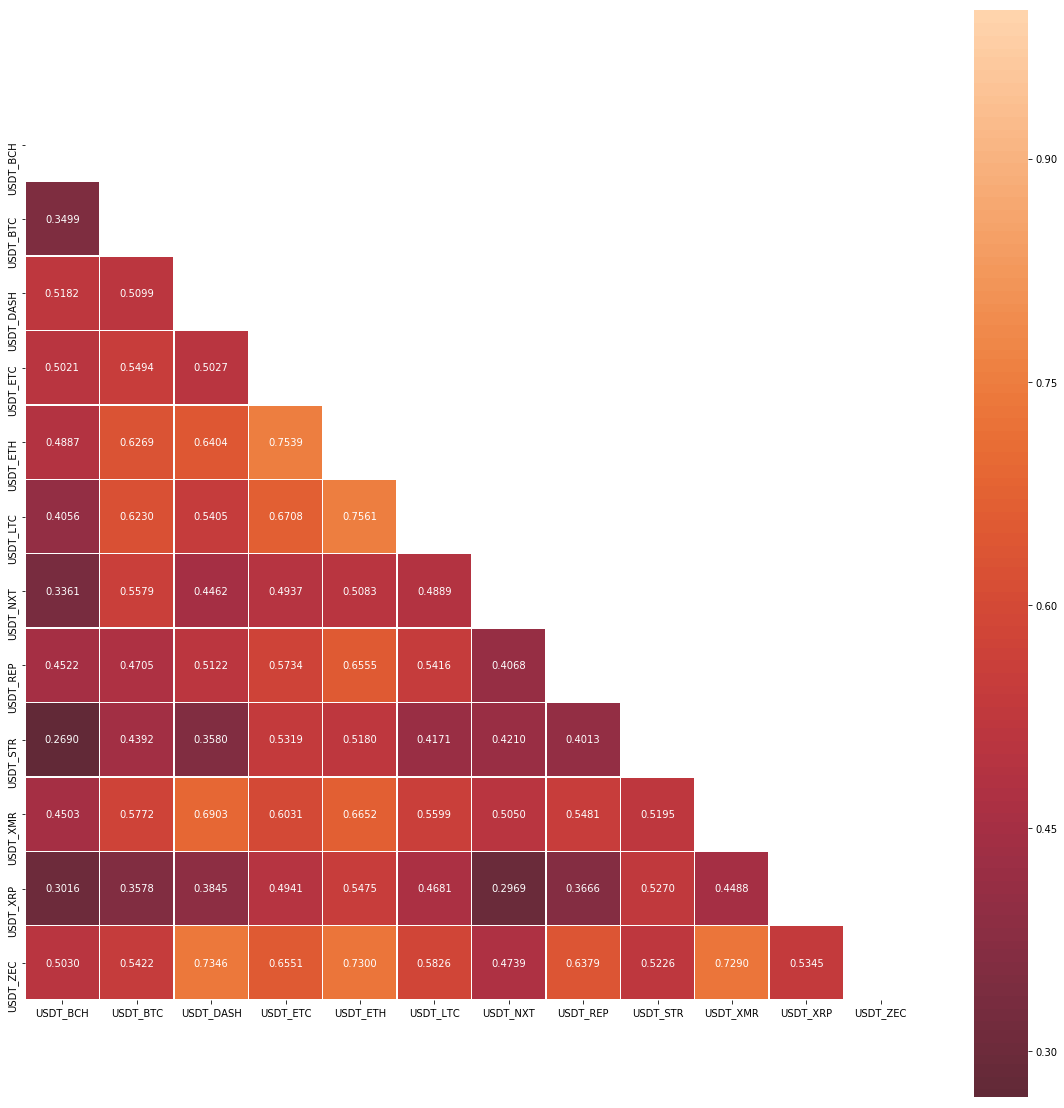

In [8]:
corr = df_prices.correlation()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

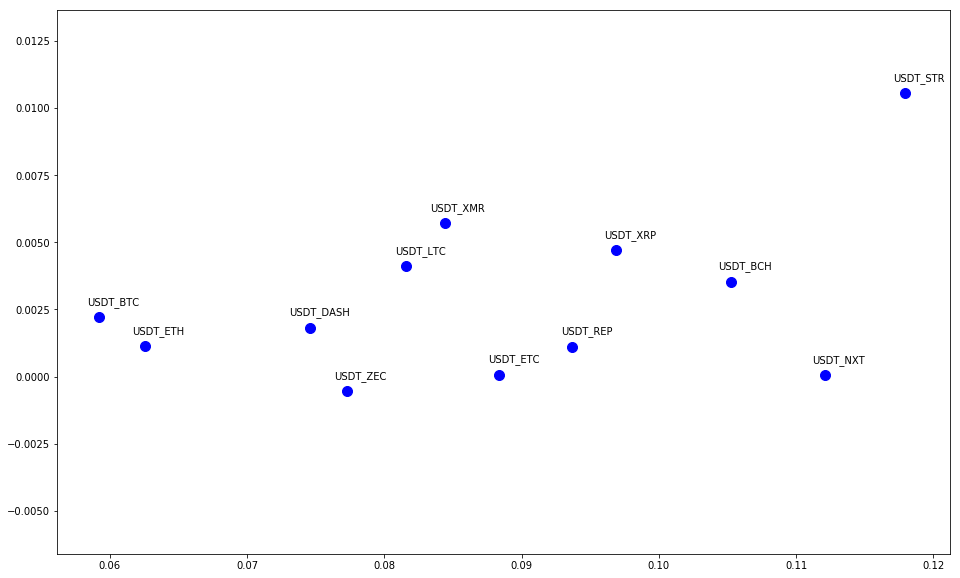

In [9]:
fig= plt.figure(figsize=(16,10))
for asset in df_prices.mean_returns().index:
    plt.scatter(df_prices.variance().loc[asset], df_prices.mean_returns().loc[asset],marker='o',color='b',s=100, label=asset)
    plt.annotate(asset,
             xy=(df_prices.variance().loc[asset], df_prices.mean_returns().loc[asset]),
             xytext=(40, 10),
             textcoords='offset points',
             ha='right',
             va='bottom')


plt.show()

In [30]:
for symbol in df_prices.mean_returns().index:
    var = value_at_risk(0.95, df_prices.mean_returns().loc[symbol], df_prices.variance().loc[symbol], 100)
    print(f'Value at risk {symbol}: {var}')

Value at risk USDT_BCH: -15.602837896417432
Value at risk USDT_BTC: -9.078403339561925
Value at risk USDT_DASH: -11.383788225895275
Value at risk USDT_ETC: -13.524009090723387
Value at risk USDT_ETH: -9.674783272076947
Value at risk USDT_LTC: -12.198188709231218
Value at risk USDT_NXT: -16.83805923617725
Value at risk USDT_REP: -14.187137739689238
Value at risk USDT_STR: -16.758605833188078
Value at risk USDT_XMR: -12.468741556004936
Value at risk USDT_XRP: -14.3332488860899
Value at risk USDT_ZEC: -11.980650202895049


In [10]:
rf = return_to_logreturn(0.000078)

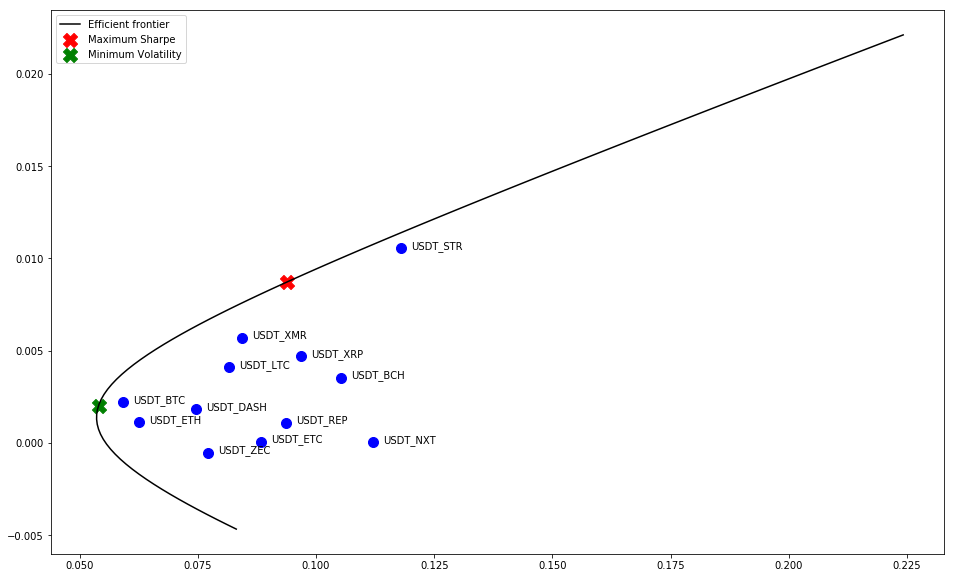

In [11]:
df_prices.plot_efficient_frontier(rf, use_negative=False)

In [12]:
ef = df_prices.efficient_frontier(rf, use_negative=True)
ef_without_neg = df_prices.efficient_frontier(rf, use_negative=False)

In [13]:
pmv_without_negative = df_prices.min_volatility(use_negative=False)
pt_without_negative = df_prices.max_sharpe(rf,use_negative=False)

In [32]:
var = value_at_risk(0.95, pmv['portfolio_return'], pmv['portfolio_volatility'], 100)
print(f'Value at risk PMV: {var}')
var = value_at_risk(0.95, pt['portfolio_return'], pt['portfolio_volatility'], 100)
print(f'Value at risk PT: {var}')

Value at risk PMV: -8.096470567453585
Value at risk PT: -18.54248429716877


In [14]:
pmv = df_prices.min_volatility()
pt = df_prices.max_sharpe(rf)

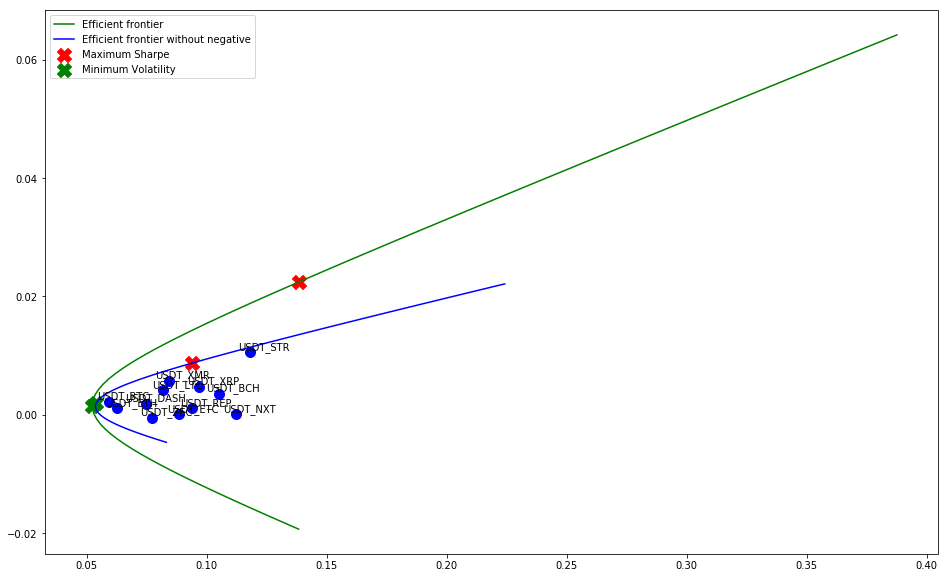

In [15]:
fig= plt.figure(figsize=(16,10))
plt.plot( 'portfolio_volatility', 'portfolio_return', data=ef, color='green')
plt.scatter(pt['portfolio_volatility'], pt['portfolio_return'], marker='X',color='r',s=200, label='Maximum Sharpe')
plt.scatter(pmv['portfolio_volatility'], pmv['portfolio_return'],marker='X',color='g',s=200, label='Minimum Volatility')
plt.plot( 'portfolio_volatility', 'portfolio_return', data=ef_without_neg, color='blue')
plt.scatter(pt_without_negative['portfolio_volatility'], pt_without_negative['portfolio_return'], marker='X',color='r',s=200, label='Maximum Sharpe')
plt.scatter(pmv_without_negative['portfolio_volatility'], pmv_without_negative['portfolio_return'],marker='X',color='g',s=200, label='Minimum Volatility')

for asset in df_prices.mean_returns().index:
    plt.scatter(df_prices.variance().loc[asset], df_prices.mean_returns().loc[asset],marker='o',color='b',s=100, label=asset)
    plt.annotate(asset,
             xy=(df_prices.variance().loc[asset], df_prices.mean_returns().loc[asset]),
             xytext=(40, 0),
             textcoords='offset points',
             ha='right',
             va='bottom')

plt.legend(['Efficient frontier','Efficient frontier without negative', 'Maximum Sharpe', 'Minimum Volatility'])
plt.show()

In [16]:
weights_pmv = pmv['weights']
weights_pt = pt['weights']
weights_pmv_without_negative = pmv_without_negative['weights']
weights_pt_without_negative = pt_without_negative['weights']

In [17]:
return_pmv = logreturn_to_return(df_prices_test.portfolio_return_for_all_period(weights_pmv))
return_pt = logreturn_to_return(df_prices_test.portfolio_return_for_all_period(weights_pt))
return_pmv_without_negative = logreturn_to_return(df_prices_test.portfolio_return_for_all_period(weights_pmv_without_negative))
return_pt_without_negative = logreturn_to_return(df_prices_test.portfolio_return_for_all_period(weights_pt_without_negative))

print(f'Retorno PMV: {return_pmv_without_negative}')
print(f'Retorno PT: {return_pt_without_negative}')

print('Com negativos')
print(f'Retorno PMV: {return_pmv}')
print(f'Retorno PT: {return_pt}')

Retorno PMV: -0.31728099888833283
Retorno PT: -0.1318440119588089
Com negativos
Retorno PMV: -0.27181971150355877
Retorno PT: 0.03236987127579205


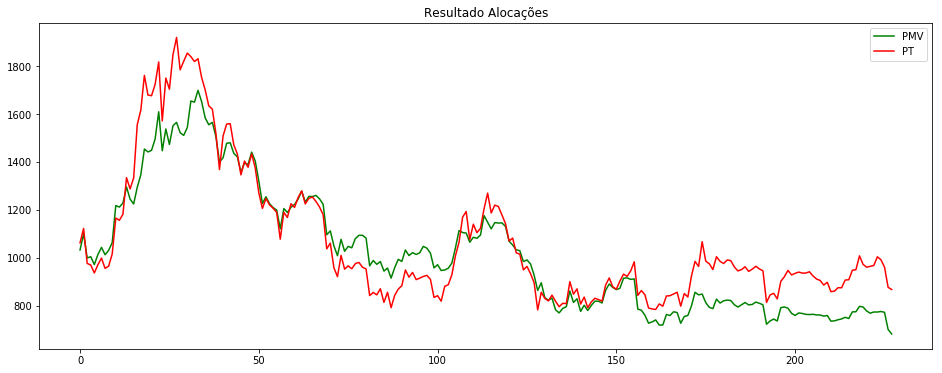

In [18]:
return_pmv = df_prices_test.portfolio_value_for_row(weights_pmv_without_negative, 1000)
return_pt = df_prices_test.portfolio_value_for_row(weights_pt_without_negative, 1000)
fig= plt.figure(figsize=(16,6))
plt.title('Resultado Alocações')
plt.plot('portfolio_return', data=return_pmv.reset_index(), color='green')
plt.plot('portfolio_return', data=return_pt.reset_index(), color='red')
plt.legend(['PMV', 'PT'])

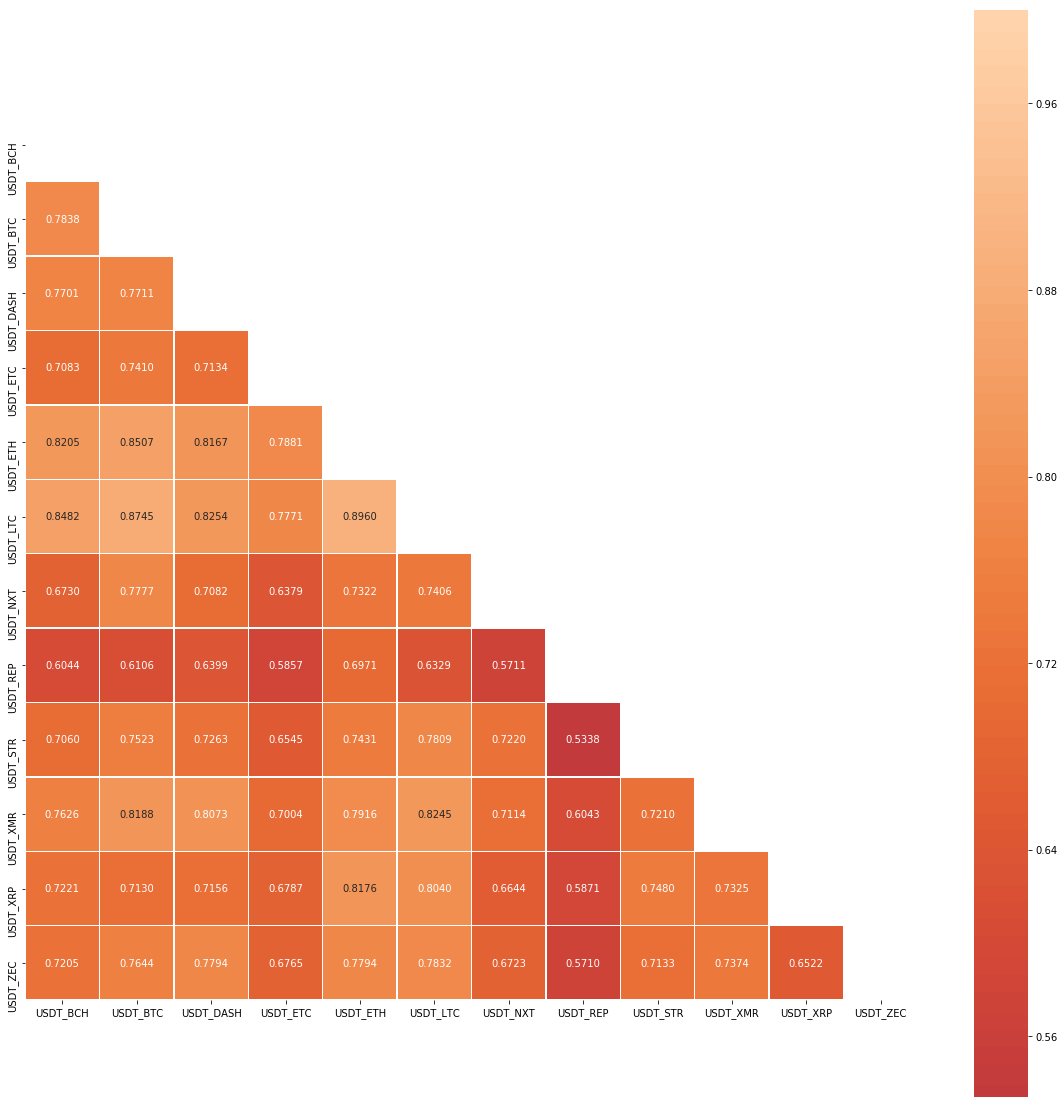

In [19]:
#Mudança de cenário 2018

corr = df_prices_test.correlation()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

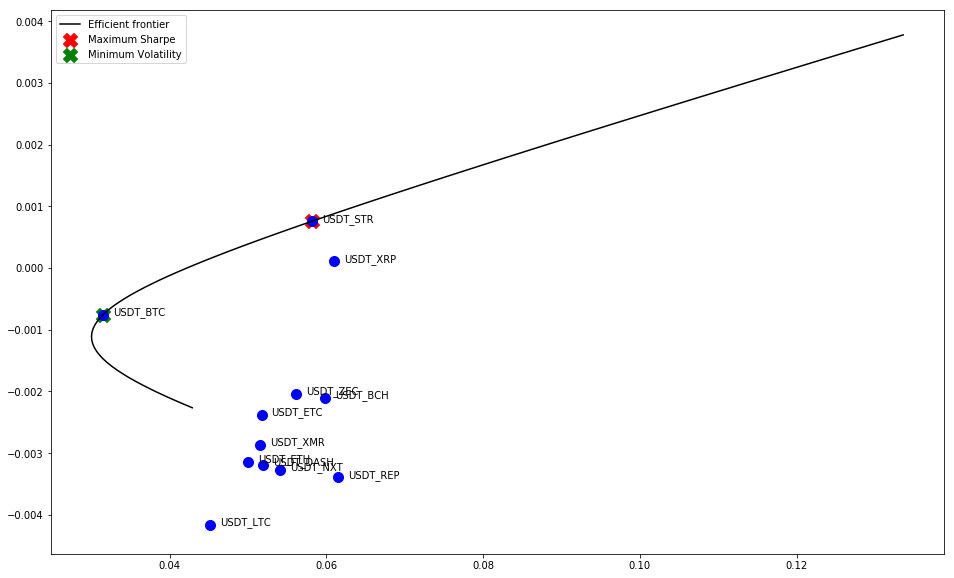

In [20]:
df_prices_test.plot_efficient_frontier(rf, use_negative=False)

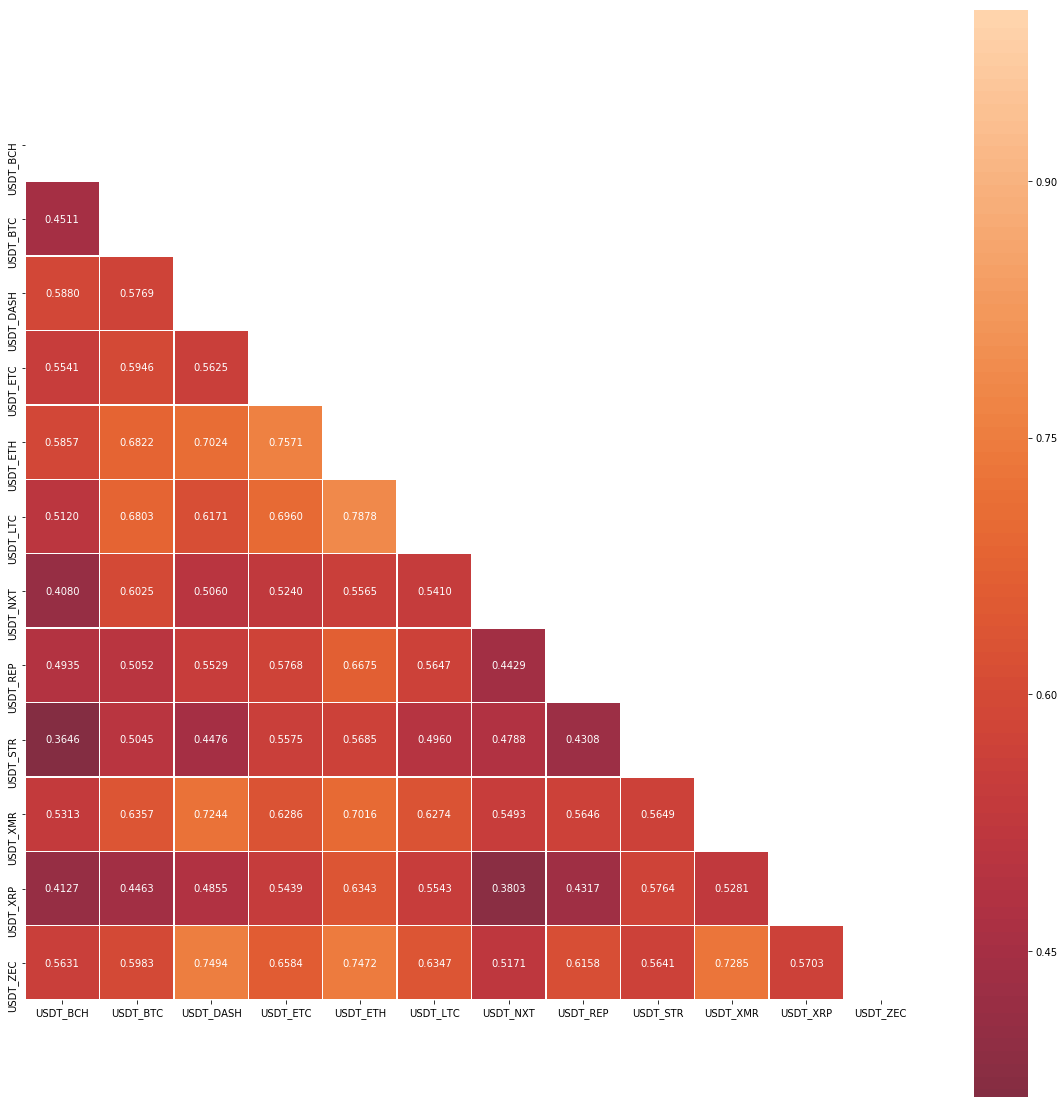

In [21]:
corr = df_prices_all.correlation()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

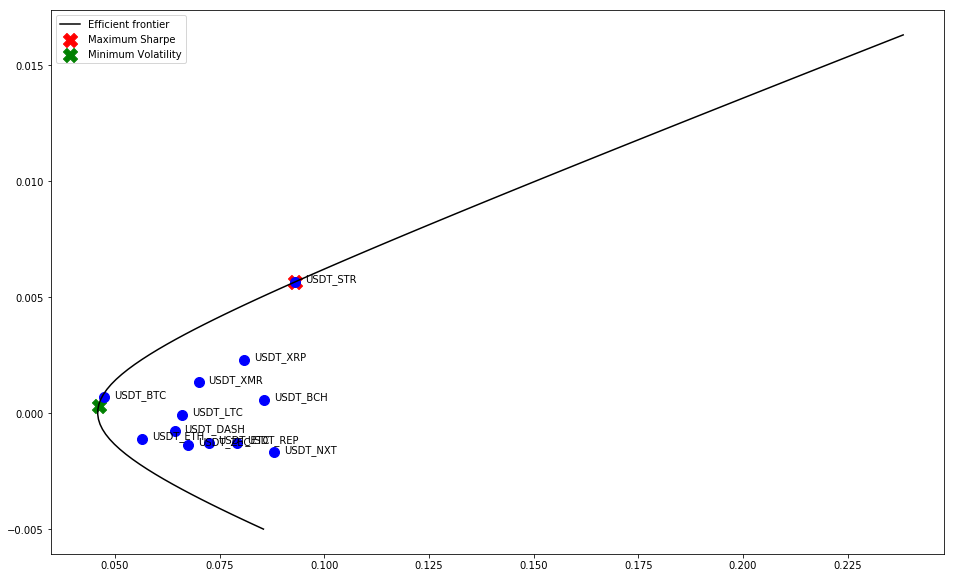

In [22]:
df_prices_all.plot_efficient_frontier(rf, use_negative=False)